### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
#!pip install -U albumentations>=0.3.0
#!pip install albumentations
#!pip install tensorflow 
#!pip install keras 
#!pip install -U --pre segmentation-models --user
#!pip install matplotlib 
#!pip install albumentations==0.0.9 --user

#!pip install opencv-python
#!pip install tensorflow
#!pip install matplotlib 
#!pip install --upgrade albumentations --user
#!pip install segmentation-models
#!pip install torch==2.5.1
#!pip install --upgrade segmentation-models tensorflow keras

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [76]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
from tensorflow import keras
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = r'D:\ESCOM\Venas\Forearm Veins (NIR)\data'


In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['veins']
    
    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # Convertir nombres de clases en índices
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        '''
        print(f"Accediendo al índice {i}")
        print(f"Ruta de la imagen: {self.images_fps[i]}")
        print(f"Ruta de la máscara: {self.masks_fps[i]}")
        '''
        
        # Leer imagen
        image = cv2.imread(self.images_fps[i])
        image = np.array(image, dtype=np.uint8)
        # Conversión explícita y verificación
        if not isinstance(image, np.ndarray):
            raise TypeError(f"Image {self.images_fps[i]} could not be read as a NumPy array")
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (320, 320))

        # Leer máscara
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (320, 320))

        # Verificar que la máscara no sea nula
        if mask is None:
            raise ValueError(f"Máscara no encontrada o inválida: {self.masks_fps[i]}")
        
        '''
        print(f"Original mask shape: {mask.shape}")
        print(f"Unique values in mask: {np.unique(mask)}")
        '''

        # Extraer clases de interés
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float32')
        
        '''
        # Validación después del apilamiento
        print(f"Processed mask shape: {mask.shape}")
        print(f"Unique values after processing: {np.unique(mask)}")
        '''

        # Manejo de fondo si es necesario
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # Aplicar aumentaciones (si existen)
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Permutar las dimensiones de la imagen (de HWC a CHW)
        image = image.transpose(2, 0, 1)  # Cambia de (H, W, C) a (C, H, W)

        # Convertir la máscara a un tensor de PyTorch y añadir una dimensión extra
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Cambiar la máscara a (C, H, W), si es binaria

        # Convertir la imagen a un tensor de PyTorch
        image = torch.tensor(image, dtype=torch.float32)          

        return image, mask

        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = [self.dataset[j] for j in range(start, stop)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

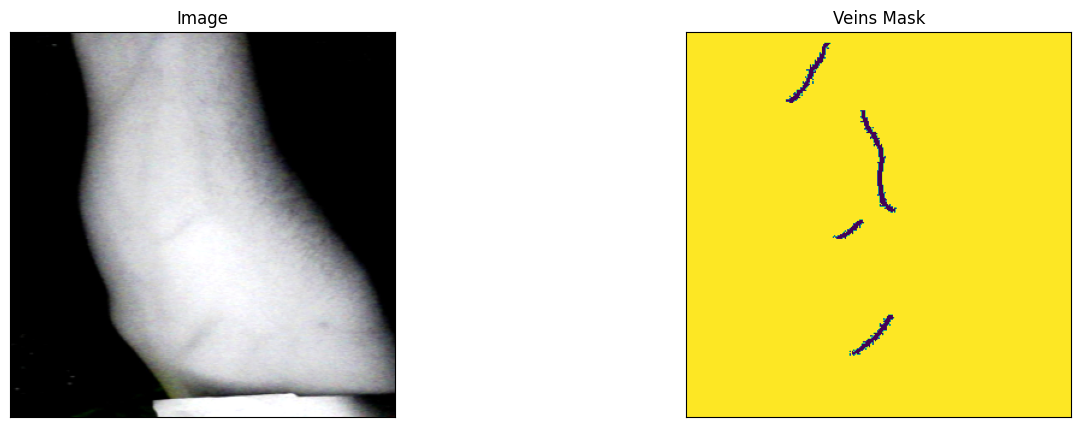

In [6]:
# Crear dataset
dataset = Dataset(x_train_dir, y_train_dir, classes=['veins'])

# Obtener un ejemplo
image, mask = dataset[1]

# Visualizar imagen y máscara
visualize(
    image=denormalize(image),
    veins_mask=mask.squeeze(),  # Eliminar dimensión extra para visualizar
)


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [7]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2

C:\Users\FrankHoshino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# Define heavy augmentations
def get_training_augmentation():
    train_transform = [
        # Flip horizontalmente para cubrir ambas orientaciones
        A.HorizontalFlip(p=0.5),
        
        # Cambios de escala y rotación
        #A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=15, shift_limit=0.05, p=1, border_mode=0),

        # Redimensionar la imagen para garantizar el tamaño uniforme
        #A.PadIfNeeded(min_height=320, min_width=320, p=1),  # Ajusta según tu dataset
        #A.RandomCrop(height=320, width=320, p=1),

        # Mejorar contraste para destacar las venas
        A.OneOf(
            [
                A.CLAHE(p=1),  # Adaptive histogram equalization
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                A.RandomGamma(gamma_limit=(80, 120), p=1),
            ],
            p=0.9,
        ),

        # Filtros para mejorar bordes y texturas
        A.OneOf(
            [
                A.Blur(blur_limit=(3, 7), p=1),  # Difumina suavemente con un kernel aleatorio dentro del rango especificado
                A.MotionBlur(blur_limit=3, p=1),         # Simula movimiento para detectar patrones
                A.GaussNoise(var_limit=(10.0, 50.0), p=1),  # Ruido para robustez
            ],
            p=0.9,
        ),

        # Transformaciones de color dirigidas
        A.OneOf(
            [
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1),
                A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=1),
            ],
            p=0.7,
        ),

        # Reemplazo de transformaciones IAA
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.Perspective(scale=(0.01, 0.05), p=0.5),

        # Normalización para estandarizar la entrada
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), p=1),
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Ajustar dimensiones para validación."""
    test_transform = [
            # Flip horizontalmente para cubrir ambas orientaciones
            A.HorizontalFlip(p=0.5),
            
            # Cambios de escala y rotación
            #A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=15, shift_limit=0.05, p=1, border_mode=0),

            # Redimensionar la imagen para garantizar el tamaño uniforme
            #A.PadIfNeeded(min_height=320, min_width=320, p=1),  # Ajusta según tu dataset
            #A.RandomCrop(height=320, width=320, p=1),

            # Mejorar contraste para destacar las venas
            A.OneOf(
                [
                    A.CLAHE(p=1),  # Adaptive histogram equalization
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                    A.RandomGamma(gamma_limit=(80, 120), p=1),
                ],
                p=0.9,
            ),

            # Filtros para mejorar bordes y texturas
            A.OneOf(
                [
                    A.Blur(blur_limit=(3, 7), p=1),  # Difumina suavemente con un kernel aleatorio dentro del rango especificado
                    A.MotionBlur(blur_limit=3, p=1),         # Simula movimiento para detectar patrones
                    A.GaussNoise(var_limit=(10.0, 50.0), p=1),  # Ruido para robustez
                ],
                p=0.9,
            ),

            # Transformaciones de color dirigidas
            A.OneOf(
                [
                    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1),
                    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=1),
                ],
                p=0.7,
            ),

            # Reemplazo de transformaciones IAA
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.Perspective(scale=(0.01, 0.05), p=0.5),

            # Normalización para estandarizar la entrada
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), p=1),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

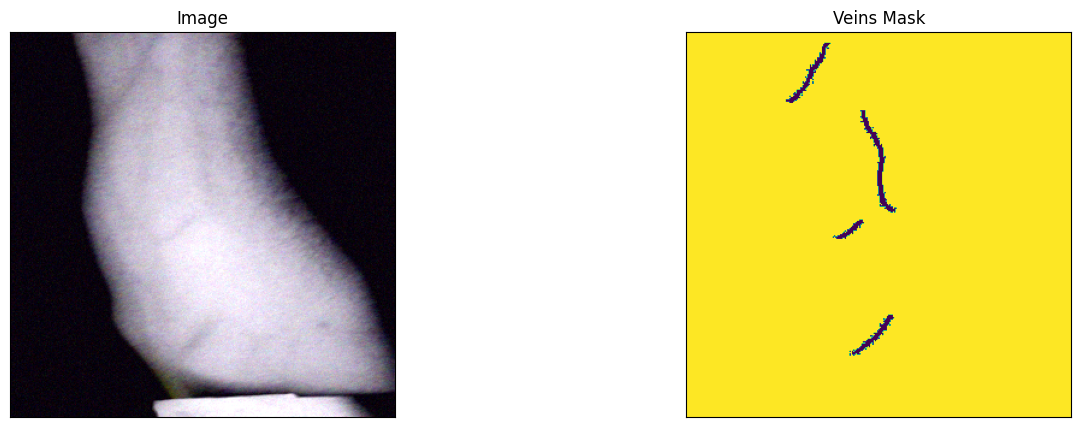

In [9]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['veins'], augmentation=get_training_augmentation())

image, mask = dataset[1] # get some sample
# Transponer la imagen para que sea compatible con Matplotlib

# Visualizar la imagen
visualize(
    image=denormalize(image),  # Asegúrate de convertir el tensor a numpy
    veins_mask=mask.squeeze()  # Eliminar dimensión extra y convertir a numpy
)

# Segmentation model training

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models_pytorch as sm

from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

from torch.utils.data import DataLoader

from torchvision.transforms.functional import normalize

from bitnet import replace_linears_in_pytorch_model


# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [53]:
BACKBONE = 'efficientnet-b3'
BATCH_SIZE = 2
CLASSES = ['veins']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.encoders.get_preprocessing_fn(BACKBONE)

In [54]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
print(n_classes)
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

replace_linears_in_pytorch_model(model)


1


In [ ]:
# define optomizer
optim = torch.optim.Adam(model.parameters(), lr=LR)

# Definir las funciones de pérdida
dice_loss = sm.losses.DiceLoss(mode='binary' if n_classes == 1 else 'multiclass')
focal_loss = sm.losses.FocalLoss(mode='binary' if n_classes == 1 else 'multiclass')

# Combinar las pérdidas
def combined_loss(y_pred, y_true):
    return dice_loss(y_pred, y_true) + (1 * focal_loss(y_pred, y_true))

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

iou_metric = BinaryJaccardIndex()
f1_metric = BinaryF1Score()

In [83]:
# Preparar dataloaders
train_dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES, 
                        augmentation=get_training_augmentation(), 
                        preprocessing=get_preprocessing(preprocess_input))

valid_dataset = Dataset(x_valid_dir, y_valid_dir, classes=CLASSES, 
                        augmentation=get_validation_augmentation(), 
                        preprocessing=get_preprocessing(preprocess_input))

# Creación de los dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

# Verificar la forma de los datos
image_batch, mask_batch = next(iter(train_loader))  # Cargar un lote de datos
print(f"Forma de las imágenes: {image_batch.shape}")  # (BATCH_SIZE, 320, 320, 3)

# Verificar la forma de las máscaras (usualmente debería estar en formato (BATCH_SIZE, 1, 320, 320))
print(f"Forma de las máscaras: {mask_batch.shape}")  # (BATCH_SIZE, 320, 320, 1)

# Verificar las formas de los datos en el val_loader
image_batch, mask_batch = next(iter(valid_loader))  # Cargar un lote de datos
print(f"Forma de las imágenes (validación): {image_batch.shape}")  # (1, 3, 320, 320)
print(f"Forma de las máscaras (validación): {mask_batch.shape}")  # (1, 1, 320, 320)


Forma de las imágenes: torch.Size([2, 3, 320, 320])
Forma de las máscaras: torch.Size([2, 1, 320, 320, 1])
Forma de las imágenes (validación): torch.Size([1, 3, 320, 320])
Forma de las máscaras (validación): torch.Size([1, 1, 320, 320, 1])


In [85]:
# Configuración del modelo y checkpoint
best_iou = 0.0
checkpoint_path = "best_model_bitnet.pth"

# Entrenamiento del modelo
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        optim.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optim.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_iou = 0.0
    val_f1 = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            outputs = model(images)
            val_loss += combined_loss(outputs, masks).item()
            val_iou += iou_metric(outputs.sigmoid(), masks.squeeze(-1).int())
            val_f1 += f1_metric(outputs.sigmoid(), masks.squeeze(-1).int())

    val_loss /= len(valid_loader)
    val_iou /= len(valid_loader)
    val_f1 /= len(valid_loader)

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Validation F1: {val_f1:.4f}")

    # Guardar el mejor modelo basado en IoU
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model weights saved at {checkpoint_path}")

Epoch 1, Validation Loss: 0.2361, Validation IoU: 0.9715, Validation F1: 0.9855
Model weights saved at best_model_bitnet.pth
Epoch 2, Validation Loss: 0.2594, Validation IoU: 0.9708, Validation F1: 0.9851
Epoch 3, Validation Loss: 0.2421, Validation IoU: 0.9730, Validation F1: 0.9863
Model weights saved at best_model_bitnet.pth
Epoch 4, Validation Loss: 0.2337, Validation IoU: 0.9721, Validation F1: 0.9858
Epoch 5, Validation Loss: 0.2314, Validation IoU: 0.9736, Validation F1: 0.9865
Model weights saved at best_model_bitnet.pth
Epoch 6, Validation Loss: 0.2280, Validation IoU: 0.9725, Validation F1: 0.9860
Epoch 7, Validation Loss: 0.2250, Validation IoU: 0.9720, Validation F1: 0.9857
Epoch 8, Validation Loss: 0.2227, Validation IoU: 0.9730, Validation F1: 0.9862
Epoch 9, Validation Loss: 0.2239, Validation IoU: 0.9725, Validation F1: 0.9860
Epoch 10, Validation Loss: 0.2202, Validation IoU: 0.9733, Validation F1: 0.9864
Epoch 11, Validation Loss: 0.2184, Validation IoU: 0.9736, Valid

Epoch 1, Train Loss: 0.1977, Train IoU: 0.9764
Validation Loss: 0.2031, Validation IoU: 0.9732, Validation F1: 0.9863
Model weights saved at best_model_bitnet.pth
Epoch 2, Train Loss: 0.1970, Train IoU: 0.9768
Validation Loss: 0.2039, Validation IoU: 0.9729, Validation F1: 0.9862
Epoch 3, Train Loss: 0.1972, Train IoU: 0.9766
Validation Loss: 0.2034, Validation IoU: 0.9735, Validation F1: 0.9865
Model weights saved at best_model_bitnet.pth
Epoch 4, Train Loss: 0.1968, Train IoU: 0.9768
Validation Loss: 0.2041, Validation IoU: 0.9722, Validation F1: 0.9858
Epoch 5, Train Loss: 0.1967, Train IoU: 0.9765
Validation Loss: 0.2025, Validation IoU: 0.9730, Validation F1: 0.9863
Epoch 6, Train Loss: 0.1962, Train IoU: 0.9775
Validation Loss: 0.2035, Validation IoU: 0.9723, Validation F1: 0.9859
Epoch 7, Train Loss: 0.1967, Train IoU: 0.9768
Validation Loss: 0.2017, Validation IoU: 0.9735, Validation F1: 0.9865
Model weights saved at best_model_bitnet.pth
Epoch 8, Train Loss: 0.1959, Train IoU:

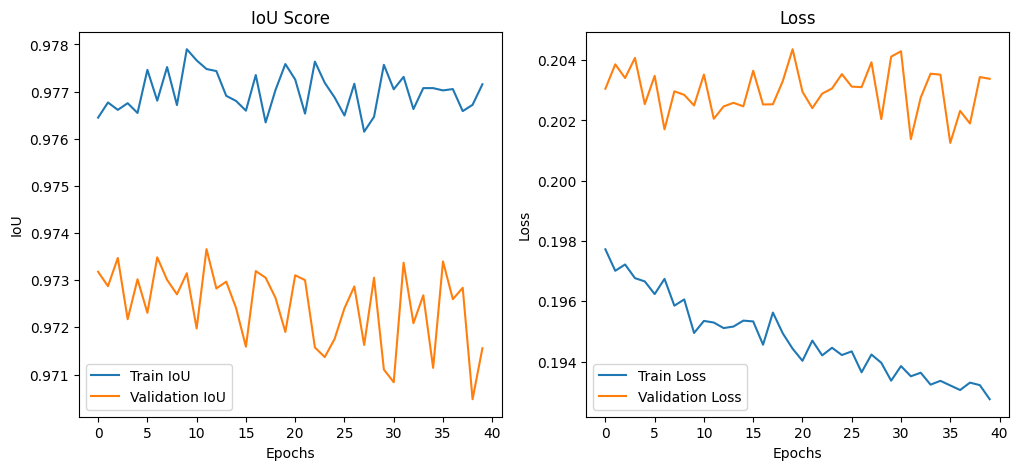

In [ ]:
# Configuración del modelo y checkpoint
best_iou = 0.0
checkpoint_path = "best_model_bitnet.pth"

# Inicializar historia
history = {
    "train_loss": [],
    "val_loss": [],
    "train_iou": [],
    "train_f1": [],
    "val_iou": [],
    "val_f1": [],
}

# Entrenamiento del modelo
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_f1 = 0.0
    for images, masks in train_loader:
        optim.zero_grad()
        outputs = model(images)
        outputs = outputs.sigmoid().round()
        loss = combined_loss(outputs, masks)
        loss.backward()
        optim.step()
        train_loss += loss.item()
        train_iou += iou_metric(outputs.sigmoid(), masks.squeeze(-1).int())
        train_f1 += f1_metric(outputs.sigmoid(), masks.squeeze(-1).int())

    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    # Validación
    model.eval()
    val_iou = 0.0
    val_f1 = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            outputs = model(images)
            val_loss += combined_loss(outputs, masks).item()
            val_iou += iou_metric(outputs.sigmoid(), masks.squeeze(-1).int())
            val_f1 += f1_metric(outputs.sigmoid(), masks.squeeze(-1).int())

    val_loss /= len(valid_loader)
    val_iou /= len(valid_loader)
    val_f1 /= len(valid_loader)

    # Actualizar historia
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_iou"].append(train_iou)
    history["val_iou"].append(val_iou)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Validation F1: {val_f1:.4f}")

    # Guardar el mejor modelo basado en IoU
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model weights saved at {checkpoint_path}")

# Graficar métricas y pérdidas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_iou"], label="Train IoU")
plt.plot(history["val_iou"], label="Validation IoU")
plt.title("IoU Score")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Model Evaluation

In [91]:
test_dataset = Dataset(x_test_dir, y_test_dir, classes=CLASSES, 
                       augmentation=get_validation_augmentation(),
                       preprocessing=get_preprocessing(preprocess_input),)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [92]:
# Cargar el modelo entrenado
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [94]:
model.eval()

# Evaluar en conjunto de prueba
test_loss = 0.0
test_iou = 0.0
test_f1 = 0.0

with torch.no_grad():
    for images, masks in test_dataloader:
        outputs = model(images)
        test_loss += combined_loss(outputs, masks).item()
        test_iou += iou_metric(outputs.sigmoid(), masks.squeeze(-1).int())
        test_f1 += f1_metric(outputs.sigmoid(), masks.squeeze(-1).int())

test_loss /= len(test_dataloader)
test_iou /= len(test_dataloader)
test_f1 /= len(test_dataloader)


print(f"Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test F1: {test_f1:.4f}")

Test Loss: 0.2036, Test IoU: 0.9723, Test F1: 0.9859


# Visualization of results on test dataset

Forma del output del modelo: torch.Size([1, 1, 320, 320])
Después de sigmoide: torch.Size([1, 1, 320, 320])
Después de squeeze: torch.Size([320, 320])
Final (NumPy): (320, 320)


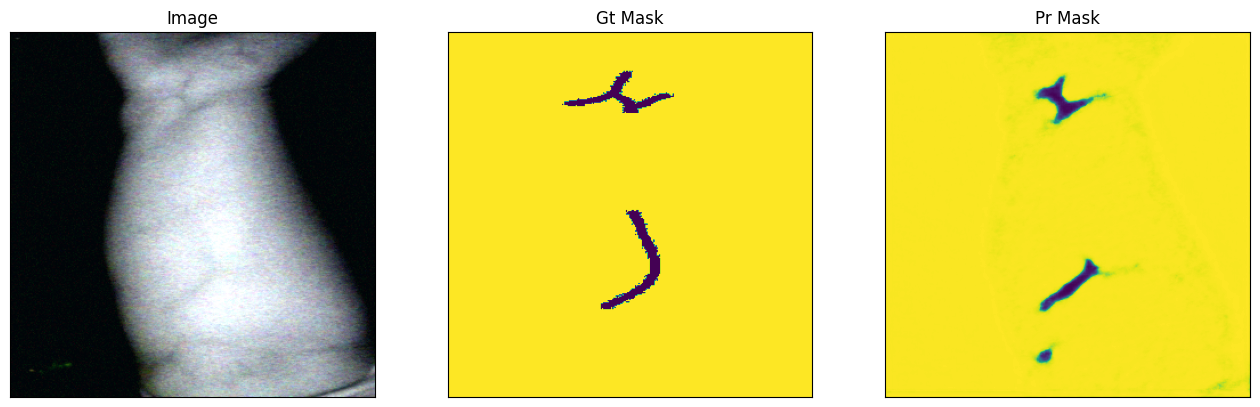

Forma del output del modelo: torch.Size([1, 1, 320, 320])
Después de sigmoide: torch.Size([1, 1, 320, 320])
Después de squeeze: torch.Size([320, 320])
Final (NumPy): (320, 320)


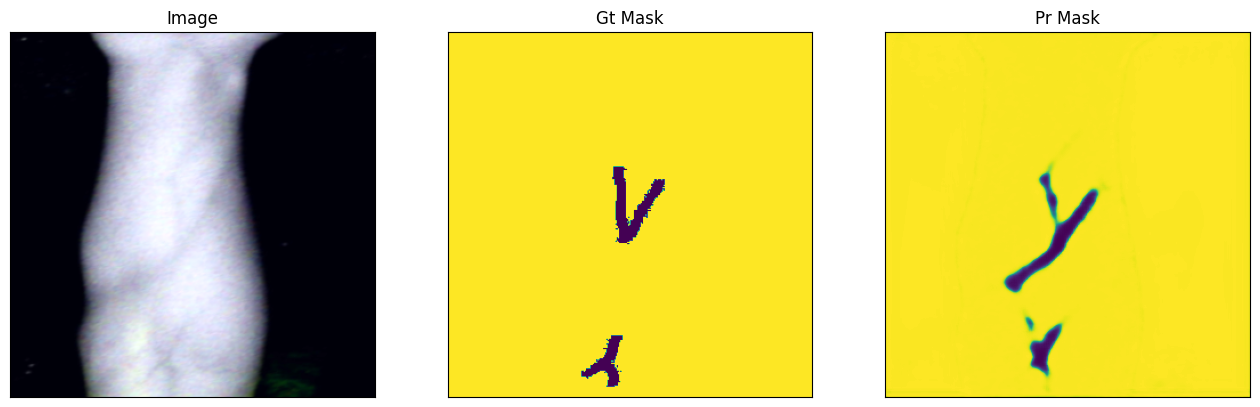

Forma del output del modelo: torch.Size([1, 1, 320, 320])
Después de sigmoide: torch.Size([1, 1, 320, 320])
Después de squeeze: torch.Size([320, 320])
Final (NumPy): (320, 320)


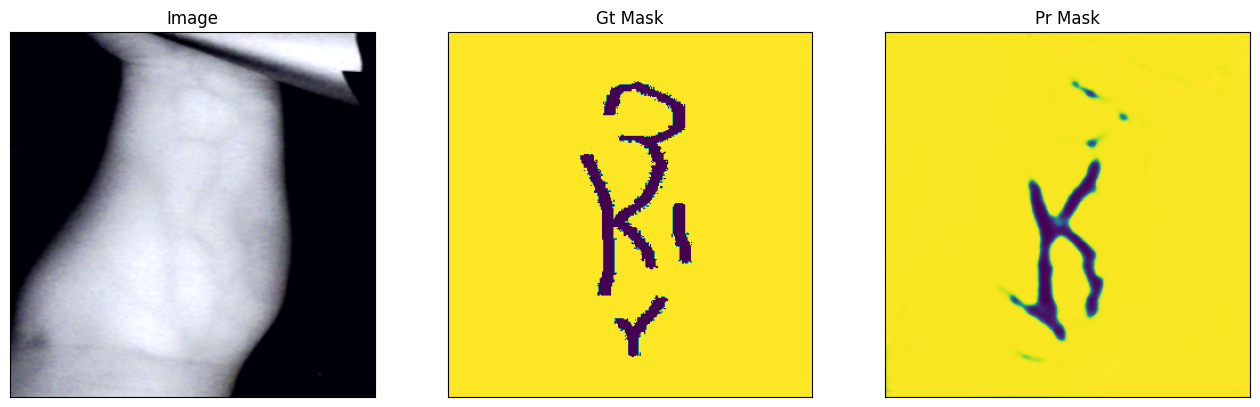

Forma del output del modelo: torch.Size([1, 1, 320, 320])
Después de sigmoide: torch.Size([1, 1, 320, 320])
Después de squeeze: torch.Size([320, 320])
Final (NumPy): (320, 320)


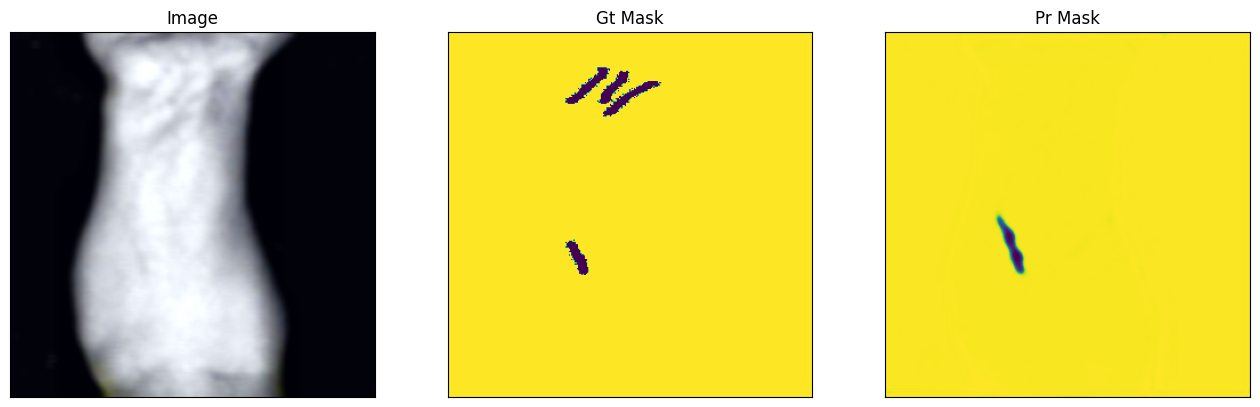

Forma del output del modelo: torch.Size([1, 1, 320, 320])
Después de sigmoide: torch.Size([1, 1, 320, 320])
Después de squeeze: torch.Size([320, 320])
Final (NumPy): (320, 320)


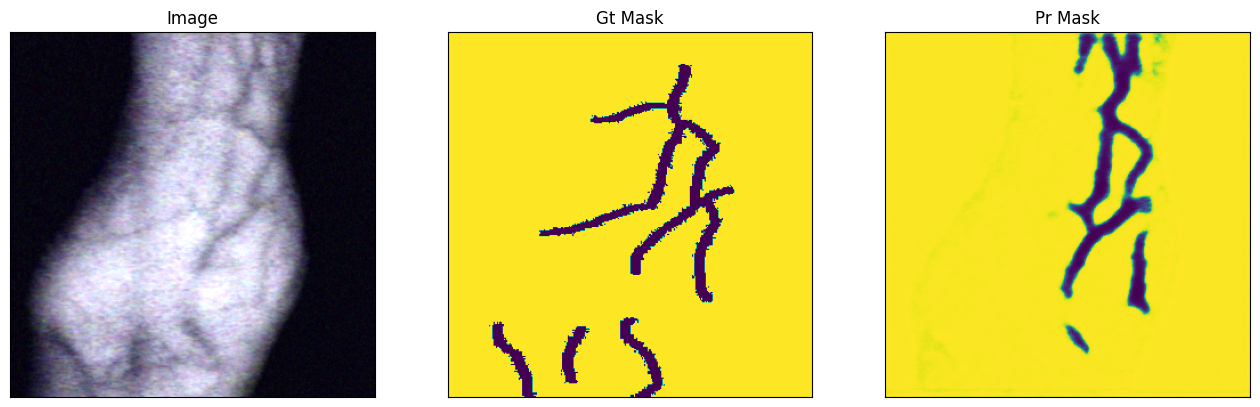

In [117]:
# Visualizar predicciones
n = 5
indices = np.random.choice(len(test_dataset), n, replace=False)

for idx in indices:
    image, gt_mask = test_dataset[idx]
    image = image.unsqueeze(0)  # Añadir dimensión batch
    outputs = model(image)
    print("Forma del output del modelo:", outputs.shape)
    outputs = outputs.sigmoid()
    print("Después de sigmoide:", outputs.shape)
    '''
    outputs = outputs.round()
    print("Después de round:", outputs.shape)
    '''
    outputs = outputs.squeeze()
    print("Después de squeeze:", outputs.shape)
    pr_mask = outputs.detach().cpu().numpy()
    print("Final (NumPy):", pr_mask.shape)

    # Denormalizar imagen para visualización
    image = normalize(image.squeeze().cpu(), mean=[0.5], std=[0.5]).numpy()
    image=image.transpose(1, 2, 0)

    # Eliminar dimensiones innecesarias para visualización
    pr_mask = pr_mask.squeeze()  # Eliminar dimensiones extra de la predicción

    # Visualizar resultados
    visualize(
        image=denormalize(image),  # Cambiar ejes para visualización
        gt_mask=gt_mask.squeeze().cpu().numpy(),  # Eliminar dimensiones extra de la máscara
        pr_mask=pr_mask
    )
